**Thành Viên: Phạm Đức Thể, Trần Triệu Vũ, Võ Minh Trí**

**MSSV: 19522253, 19522539, 19522396**

**Lớp: DS200.M21**

**Nội Dung: [Bài tập Kaggle 2](https://www.kaggle.com/competitions/kaggle-assignment-2)**

**[Dataset](https://drive.google.com/drive/folders/11dah8AyLOOY-kjpfJ8xd18axDKc-0JPf?usp=sharing)**

**Ngày: 26/05/2022** 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1szsdxTsGSJ6MMr9__yaaAE6BfJcwe3vz?usp=sharing)

# **Big Data - UIT DS200 Kaggle Assignment 6**

## **Import Library**

In [1]:
!pip install pyspark==3.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 204.2 MB 29 kB/s 
     |████████████████████████████████| 198 kB 48.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=60bda08d2c53725553b6105e8f78cd2e228f9a94e9aaacbb8c955344024b8793
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark


In [2]:
import numpy as np
import pandas
import time
import seaborn as sns

from IPython.core.display import display
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.sql import functions as f
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StopWordsRemover, RegexTokenizer, HashingTF, IDF, Tokenizer, CountVectorizer, Word2Vec
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pprint import pprint
from textblob import TextBlob

sns.set()

spark = SparkSession.builder.appName('BigDataAssignment6').config("spark.executor.memory","8g").getOrCreate()
spark

## **Read Data**

In [3]:
PATH = '/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 2 2021 - 2022/DS200.M21 - PHÂN TÍCH DỮ LIỆU LỚN/THỰC HÀNH/LAB/Lab SparkML - 28 04 2022/Slide 10 - PySpark dataset/'
schemaTrain = 'polarity FLOAT, id LONG, date_time STRING, query STRING, user STRING, text STRING'

In [4]:
# Read train.csv
train_data = spark.read.csv(PATH+'training.1600000.processed.noemoticon.csv', header=False, schema=schemaTrain)
train_data.printSchema()
train_data.show(20,False)
train_data.count()

root
 |-- polarity: float (nullable = true)
 |-- id: long (nullable = true)
 |-- date_time: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

+--------+----------+----------------------------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+
|polarity|id        |date_time                   |query   |user           |text                                                                                                                 |
+--------+----------+----------------------------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+
|0.0     |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D 

1600000

In [5]:
test_data = spark.read.csv(PATH+'testdata.manual.2009.06.14.csv', header=False, schema=schemaTrain)
test_data.printSchema()
test_data.show(20,False)
test_data.count()

root
 |-- polarity: float (nullable = true)
 |-- id: long (nullable = true)
 |-- date_time: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

+--------+---+----------------------------+-------+--------------+--------------------------------------------------------------------------------------------------------------------------------------------+
|polarity|id |date_time                   |query  |user          |text                                                                                                                                        |
+--------+---+----------------------------+-------+--------------+--------------------------------------------------------------------------------------------------------------------------------------------+
|4.0     |3  |Mon May 11 03:17:40 UTC 2009|kindle2|tpryan        |@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is

498

In [6]:
train = train_data.select('id','text','polarity')
train.printSchema()
train.show(20,False)
train.count()

root
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- polarity: float (nullable = true)

+----------+---------------------------------------------------------------------------------------------------------------------+--------+
|id        |text                                                                                                                 |polarity|
+----------+---------------------------------------------------------------------------------------------------------------------+--------+
|1467810369|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  |0.0     |
|1467810672|is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!      |0.0     |
|1467810917|@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                            |0.0     |
|1467811184|my whole body feels itchy and like 

1600000

In [7]:
test = test_data.select('id','text','polarity')
test.printSchema()
test.show(20,False)
test.count()

root
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- polarity: float (nullable = true)

+---+--------------------------------------------------------------------------------------------------------------------------------------------+--------+
|id |text                                                                                                                                        |polarity|
+---+--------------------------------------------------------------------------------------------------------------------------------------------+--------+
|3  |@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.                             |4.0     |
|4  |Reading my kindle2...  Love it... Lee childs is good read.                                                                                  |4.0     |
|5  |Ok, first assesment of the #kindle2 ...it fucking rocks!!!                                            

498

### distribution of polarity train

No of rows with Polarity: 1600000/1600000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


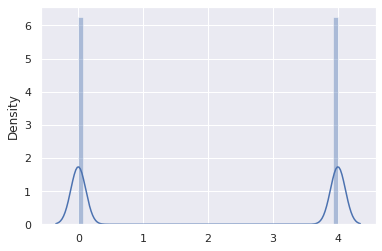

In [8]:
df = train.select('polarity').na.drop()
print(f'No of rows with Polarity: {df.count()}/{train.count()}')

sns.distplot(df.toPandas())

In [9]:
polarity_df = train.select('polarity').cache()

polarity_df.groupBy('polarity').count().toPandas()

,polarity,count
0,4.0,800000
1,0.0,800000


### distribution of polarity test

No of rows with Polarity: 498/498


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


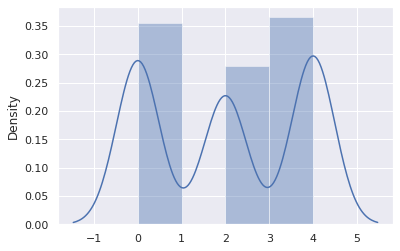

In [10]:
df = test.select('polarity').na.drop()
print(f'No of rows with Polarity: {df.count()}/{test.count()}')

sns.distplot(df.toPandas())

In [11]:
polarity_df = test.select('polarity').cache()

polarity_df.groupBy('polarity').count().toPandas()

,polarity,count
0,2.0,139
1,4.0,182
2,0.0,177


## **Text Pre-processing**

In [12]:
def cleaning_process(data):
  user_regex = r'(@\w{1,15})'
  hashtag_replace_regex = '(#\w{1,})'
  data_new = data.withColumn('users_mentioned', (f.array_remove(f.array(f.regexp_extract(f.col('text'), user_regex, 1),
                                                                        f.regexp_extract(f.col('text'), ''.join([f'{user_regex}.*?' for i in range(0,2)]), 2),
                                                                        f.regexp_extract(f.col('text'), ''.join([f'{user_regex}.*?' for i in range(0,3)]), 3),
                                                                        f.regexp_extract(f.col('text'), ''.join([f'{user_regex}.*?' for i in range(0,4)]), 4),
                                                                        f.regexp_extract(f.col('text'), ''.join([f'{user_regex}.*?' for i in range(0,5)]), 5),
                                                                        f.regexp_extract(f.col('text'), ''.join([f'{user_regex}.*?' for i in range(0,6)]), 6),),'',))) \
                  .withColumn('hashtags', f.array_remove(f.array(f.regexp_extract(f.col('text'), hashtag_replace_regex, 1),
                                                                 f.regexp_extract(f.col('text'), ''.join([f'{hashtag_replace_regex}.*?' for i in range(0,2)]), 2),
                                                                 f.regexp_extract(f.col('text'), ''.join([f'{hashtag_replace_regex}.*?' for i in range(0,3)]), 3),
                                                                 f.regexp_extract(f.col('text'), ''.join([f'{hashtag_replace_regex}.*?' for i in range(0,4)]), 4),
                                                                 f.regexp_extract(f.col('text'), ''.join([f'{hashtag_replace_regex}.*?' for i in range(0,5)]), 5),
                                                                 f.regexp_extract(f.col('text'), ''.join([f'{hashtag_replace_regex}.*?' for i in range(0,6)]), 6),),'',))
                    
  return data_new

In [13]:
train_cleaning = cleaning_process(train)
test_cleaning = cleaning_process(test)

In [14]:
train_cleaning.printSchema()
train_cleaning.show(20,False)
train_cleaning.count()

root
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- polarity: float (nullable = true)
 |-- users_mentioned: array (nullable = false)
 |    |-- element: string (containsNull = true)
 |-- hashtags: array (nullable = false)
 |    |-- element: string (containsNull = true)

+----------+---------------------------------------------------------------------------------------------------------------------+--------+-------------------------------+--------+
|id        |text                                                                                                                 |polarity|users_mentioned                |hashtags|
+----------+---------------------------------------------------------------------------------------------------------------------+--------+-------------------------------+--------+
|1467810369|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  |0.0     |[@switchfoot]         

1600000

In [15]:
test_cleaning.printSchema()
test_cleaning.show(20,False)
test_cleaning.count()

root
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- polarity: float (nullable = true)
 |-- users_mentioned: array (nullable = false)
 |    |-- element: string (containsNull = true)
 |-- hashtags: array (nullable = false)
 |    |-- element: string (containsNull = true)

+---+--------------------------------------------------------------------------------------------------------------------------------------------+--------+----------------+----------+
|id |text                                                                                                                                        |polarity|users_mentioned |hashtags  |
+---+--------------------------------------------------------------------------------------------------------------------------------------------+--------+----------------+----------+
|3  |@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.                             |4.0   

498

In [16]:
df_training = (
    train_cleaning
    # Remove all numbers
    .withColumn("text", f.regexp_replace(f.col("text"), "[^a-zA-Z]", " "))
    # Remove all double/multiple spaces
    .withColumn("text", f.regexp_replace(f.col("text"), " +", " "))
    # Remove leading and training whitespaces
    .withColumn("text", f.trim(f.col("text")))
    # Ensure we don't end up with empty rows
    .filter("text != ' '"))
Train = df_training.select("text", "polarity").coalesce(3).cache()
Train.printSchema()
Train.show(20,False)
Train.count()

root
 |-- text: string (nullable = true)
 |-- polarity: float (nullable = true)

+-------------------------------------------------------------------------------------------------------------+--------+
|text                                                                                                         |polarity|
+-------------------------------------------------------------------------------------------------------------+--------+
|switchfoot http twitpic com y zl Awww that s a bummer You shoulda got David Carr of Third Day to do it D     |0.0     |
|is upset that he can t update his Facebook by texting it and might cry as a result School today also Blah    |0.0     |
|Kenichan I dived many times for the ball Managed to save The rest go out of bounds                           |0.0     |
|my whole body feels itchy and like its on fire                                                               |0.0     |
|nationwideclass no it s not behaving at all i m mad why am i here becau

1600000

In [17]:
df_test = (
    test_cleaning
    # Remove all numbers
    .withColumn("text", f.regexp_replace(f.col("text"), "[^a-zA-Z]", " "))
    # Remove all double/multiple spaces
    .withColumn("text", f.regexp_replace(f.col("text"), " +", " "))
    # Remove leading and training whitespaces
    .withColumn("text", f.trim(f.col("text")))
    # Ensure we don't end up with empty rows
    .filter("text != ' '"))
Test = df_test.select('id', "text").coalesce(3).cache()
Test.printSchema()
Test.show(20,False)
Test.count()

root
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)

+---+----------------------------------------------------------------------------------------------------------------------------------------+
|id |text                                                                                                                                    |
+---+----------------------------------------------------------------------------------------------------------------------------------------+
|3  |stellargirl I loooooooovvvvvveee my Kindle Not that the DX is cool but the is fantastic in its own right                                |
|4  |Reading my kindle Love it Lee childs is good read                                                                                       |
|5  |Ok first assesment of the kindle it fucking rocks                                                                                       |
|6  |kenburbary You ll love your Kindle I ve had mine for a few mont

498

## **Build Model**

### Build Pipeline

In [18]:
# Create pipeline processing data and model
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="words1", 
                                     stopWords=StopWordsRemover.loadDefaultStopWords("english"))
hashing_tf = HashingTF(numFeatures=2**17, inputCol="words1", outputCol='term_frequency')
idf = IDF(inputCol='term_frequency', outputCol="features", minDocFreq=25) #minDocFreq: remove sparse terms
# label_stringIdx = StringIndexer(inputCol = "polarity", outputCol = "label")
lr = LogisticRegression(maxIter=300, regParam = 0.005, elasticNetParam=0.8, featuresCol="features", labelCol="polarity")

pipeline = Pipeline(stages=[regexTokenizer, stopwords_remover, hashing_tf, idf, lr])

**Model:**

```python
# Create pipeline processing data and model
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="words1", 
                                     stopWords=StopWordsRemover.loadDefaultStopWords("english"))
hashing_tf = HashingTF(numFeatures=2**16, inputCol="words1", outputCol='term_frequency')
idf = IDF(inputCol='term_frequency', outputCol="features", minDocFreq=25) #minDocFreq: remove sparse terms
# label_stringIdx = StringIndexer(inputCol = "polarity", outputCol = "label")
lr = LogisticRegression(maxIter=300, regParam = 0.005, featuresCol="features", labelCol="polarity")

pipeline = Pipeline(stages=[regexTokenizer, stopwords_remover, hashing_tf, idf, lr])
```



### Parameter Tunning Using A Grid Search

[Reference](http://michael-harmon.com/blog/SentimentAnalysisP2.html)

In [19]:
parameter_grid = (ParamGridBuilder() \
                  .addGrid(hashing_tf.numFeatures, [2**16,2**17]) \
                  # .addGrid(idf.minDocFreq, [5,10,15]) \
                  .addGrid(lr.maxIter, [50,100,300]) \
                  # .addGrid(lr.fitIntercept, [False, True]) \
                  .addGrid(lr.regParam, [0.001, 0.003, 0.005]).build())

In [20]:
pprint(parameter_grid)

[{Param(parent='HashingTF_e45b37cdd78c', name='numFeatures', doc='Number of features. Should be greater than 0.'): 65536,
  Param(parent='LogisticRegression_7ad92c7a23ad', name='maxIter', doc='max number of iterations (>= 0).'): 50,
  Param(parent='LogisticRegression_7ad92c7a23ad', name='regParam', doc='regularization parameter (>= 0).'): 0.001},
 {Param(parent='HashingTF_e45b37cdd78c', name='numFeatures', doc='Number of features. Should be greater than 0.'): 65536,
  Param(parent='LogisticRegression_7ad92c7a23ad', name='maxIter', doc='max number of iterations (>= 0).'): 50,
  Param(parent='LogisticRegression_7ad92c7a23ad', name='regParam', doc='regularization parameter (>= 0).'): 0.003},
 {Param(parent='HashingTF_e45b37cdd78c', name='numFeatures', doc='Number of features. Should be greater than 0.'): 65536,
  Param(parent='LogisticRegression_7ad92c7a23ad', name='maxIter', doc='max number of iterations (>= 0).'): 50,
  Param(parent='LogisticRegression_7ad92c7a23ad', name='regParam', do

In [21]:
crossvalidator = CrossValidator(estimator=pipeline, estimatorParamMaps=parameter_grid, numFolds=2, 
                                evaluator= MulticlassClassificationEvaluator(labelCol='polarity', 
                                                                             metricName='accuracy'))

In [ ]:
%%time
# start = time.time()
crossval_model = crossvalidator.fit(Train)
# model = pipeline.fit(Train)
# end = time.time()
# print(f'Completed: {(end-start)/60} minute')

### Best Model

In [ ]:
model = crossval_model.bestModel

In [ ]:
model.stages

In [ ]:
model.stages[2].explainParam('minDocFreq')

In [ ]:
model.stages[-1].explainParam('regParam')

In [ ]:
summary = model.stages[-1].summary
summary

In [ ]:
Trained = model.transform(Train)
Trained.show()

In [ ]:
Tested = model.transform(Test)
Tested.show()

In [ ]:
%%time

evaluator = MulticlassClassificationEvaluator(labelCol='polarity', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
accuracy_test = evaluator.evaluate(Tested)

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print('='*15+'Test Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')

**Output:**

```python
===============Training Data===============
Accuracy: 78.61006%
===============Test Data===============
Accuracy: 57.22892%
CPU times: user 3.53 s, sys: 520 ms, total: 4.05 s
Wall time: 8min 48s
```



## **Prediction**

### Predict on Test

In [ ]:
predictions = model.transform(Test)
predictions.show()
predictions.count()

In [ ]:
pred = predictions.select('id', 'text', 'probability', 'prediction')
pred.show()
pred.count()

In [ ]:
def get_polarity(s):
    return TextBlob(s).sentiment.polarity

In [ ]:
udf1 = f.udf(get_polarity, FloatType())
pred = pred.withColumn('sentiment', udf1(f.col('text')))
pred.show()
pred.count()

In [ ]:
pred = pred.withColumn('polarity',f.when(f.col('sentiment')<0, 0).when(f.col('sentiment')==0, 2).otherwise(4))
pred.show()
pred.count()

In [ ]:
pred = pred.withColumn('prob', f.col('probability').cast("string").substr(2,4).cast("float"))
pred.show()
pred.count()

### Final Result

In [ ]:
final = pred.withColumn('polarity', f.when((f.col('polarity')==4) & (f.col('prob')>0.58),2).otherwise(f.col('polarity')))
final.show()
final.count()

In [ ]:
final = final.withColumn('polarity', f.when((f.col('polarity')==2) & (f.col('prob')>0.62),0).otherwise(f.col('polarity')))
final.show()
final.count()

In [ ]:
final.groupBy('polarity').agg(f.count(f.col('polarity'))/498).show()

In [ ]:
final.groupBy('prediction').agg(f.count(f.col('prediction'))).show()

**Output:**

```python
+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|       0.0|              190|
|       4.0|              308|
+----------+-----------------+
```



In [ ]:
final_df = final.select('id','polarity').toPandas()
final_df.to_csv('submission.csv', header=True, index=False)

In [ ]:
final_df